In [112]:
import pandas as pd
import random as rand
import seaborn as sb
import requests
import time
from concurrent.futures import ThreadPoolExecutor, as_completed
import json
import os

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score




In [151]:
final_data = pd.read_csv("final_data.csv")

In [18]:
final_data.head()

,pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name,Genre
0,0,Missy Elliott,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,spotify:artist:2wIVse2owClT7go1WT98tk,Lose Control (feat. Ciara & Fat Man Scoop),spotify:album:6vV5UrXcfyQD1wu4Qo2I9K,226863,The Cookbook,hip hop
1,1,Britney Spears,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,spotify:artist:26dSoYclwsYLMAKD3tpOr4,Toxic,spotify:album:0z7pVBGOD7HCIB7S8eLkLI,198800,In The Zone,pop
2,2,Beyoncé,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,spotify:artist:6vWDO969PvNqNYHIOW5v0m,Crazy In Love,spotify:album:25hVFAxTlDvXbx2X2QkUkE,235933,Dangerously In Love (Alben für die Ewigkeit),NaN
3,3,Justin Timberlake,spotify:track:1AWQoqb9bSvzTjaLralEkT,spotify:artist:31TPClRtHm23RisEBtV3X7,Rock Your Body,spotify:album:6QPkyl04rXwTGlGlcYaRoW,267266,Justified,NaN
4,4,Shaggy,spotify:track:1lzr43nnXAijIGYnCT8M8H,spotify:artist:5EvFsr3kj42KNv97ZEnqij,It Wasn't Me,spotify:album:6NmFmPX56pcLBOFMhIiKvF,227600,Hot Shot,reggae


In [ ]:
final_data = pd.DataFrame({})

def getJson(dir):
    with open(dir, 'r') as file:
        data = json.load(file)

    return data

def process_playlist(playlist, playlist_index, playlistCount):
    """Process a single playlist and return its tracks as a DataFrame."""
    local_tracks = []
    trackCount = len(playlist['tracks'])
    for f, track in enumerate(playlist['tracks'], start=1):
        local_tracks.append(track)
        # Note: printing from multiple threads may jumble output.
        #print(f"Progress: {f}/{trackCount} (on playlist {playlist_index}/{playlistCount})")
    return pd.DataFrame(local_tracks)

def getalltracks(data, max_workers=4):
    """Returns a DataFrame containing all tracks from all playlists using multithreading."""
    playlists = data['playlists']
    playlistCount = len(playlists)
    
    # Use ThreadPoolExecutor to process each playlist concurrently
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Submit a job for each playlist
        futures = [executor.submit(process_playlist, playlist, i, playlistCount)
                   for i, playlist in enumerate(playlists)]
        
        # Collect all the DataFrames as they complete
        df_list = []
        for future in as_completed(futures):
            try:
                df_list.append(future.result())
            except Exception as e:
                print("Error processing a playlist:", e)
    
    # Concatenate all DataFrames from the playlists into one
    retDict = pd.concat(df_list, axis=0, ignore_index=True)
    return retDict

files = os.listdir('Million Playlist')
tracks_list = []

i = 0

for file in files:
    tracks = getalltracks(getJson(f'Million Playlist\{file}'))

    tracks_list.append(tracks)

    i+=1

    print(f"Progress: {i}/{len(files)}")


final_data = pd.concat(tracks_list, axis=0, ignore_index=True)

In [ ]:
ACCESS_TOKEN = "BQDFavo8fE5NhzayKb-MCcj4WoWjTc6emYhjg0FOSCmaaT30uVNglYebrEmTF7tU6SpMLMgEYTvi9B9s1nUuU0PafajR7fgpLnPGqCMf9bb2KD_npAtc4FToG2Clxc9eQXPuoko9tVE"

def get_artist_genre(artist_id):
    """Fetches genres for a given artist ID from Spotify API."""
    url = f"https://api.spotify.com/v1/artists/{artist_id}"
    headers = {"Authorization": f"Bearer {ACCESS_TOKEN}"}

    response = requests.get(url, headers=headers)
    
    if response.status_code == 200:
        artist_data = response.json()
        return artist_id, artist_data.get("genres", [])  # Return (artist_id, genres)
    elif response.status_code == 429:  # Handle Rate Limiting
        print("Rate limited! Waiting before retrying...")
        time.sleep(5)  # Wait before retrying
        return get_artist_genre(artist_id)  # Retry request
    else:
        print(f"Error fetching artist {artist_id}: {response.status_code}")
        return artist_id, None  # Return None for failed requests
    

rows_with_none_artist_uri = final_data[final_data['Genre'].isna()]['artist_uri'].unique()
artist_ids = [artist.split(":")[2] for artist in rows_with_none_artist_uri]


    
i = 0
    
for artist in artist_ids:
    final_data.loc[final_data['artist_uri'] == artist, 'Genre'] = get_artist_genre(artist)
    i+=1

    print(f"progress: {i}/{len(artist_ids)}")
    

Rate limited! Waiting before retrying...
Rate limited! Waiting before retrying...
Rate limited! Waiting before retrying...
Rate limited! Waiting before retrying...


KeyboardInterrupt: 

In [ ]:
ACCESS_TOKEN = "BQAxgfmRTL14h6gKKd8RjwVOxwBkGsx5235sG7Iux7W_zhStCrMWHRfP1j9F3IF4UzE4_0mXGp_f15BxT9ncfe0_Bh1xctAj_JctmH5BAHvPEA-cRCwkmdmvPDaWO7KDHL8QalG_hnM"
endpoint = "https://api.spotify.com/v1/albums/" # id 

def getReleaseYear(albumId):
    response = requests.get(endpoint + albumID, headers={"Authorization":f"Bearer {ACCESS_TOKEN}"})

    if response.status_code == 200:
        return response.json()['release_date'].split('-')[0]
    elif response.status_code == 429:
        retry = response.headers.get("Retry-After")
        print(f"Rate limited! Waiting {retry}")
        time.sleep(retry)
        return getReleaseYear(albumId)
    elif response.status_code == 404:
        print(f"Failed for {albumID}, content doesn't exist")
        return None
    

    print(response.json())
    response.json()['release_date'].split('-')[0]

albums = final_data[final_data['releaseYear'].isna()]['album_uri'].unique()

i = 0

for album in albums:
    albumID = album.split(":")[2]

    releaseYear = getReleaseYear(albumID)

    if releaseYear:
        final_data.loc[final_data['album_uri'] == album, "releaseYear"] = int(releaseYear)

    i+=1

    print(f"Progress: {i}/{len(albums)}")




Failed for 324ychEJu5FNpV2lI6hLxI, content doesn't exist
Progress: 1/5979
Failed for 4MSG5XbntSyl6VeaMGIYl5, content doesn't exist
Progress: 2/5979
Failed for 4lDKfTNmcOWWe3PCyty5PA, content doesn't exist
Progress: 3/5979
Failed for 0skM2aGqJyqfbjs2W44gRh, content doesn't exist
Progress: 4/5979
Failed for 6HoX2FB2D3l7nhgzi9OXRW, content doesn't exist
Progress: 5/5979
Failed for 7mFAkcGd02JOs24Vp1idhd, content doesn't exist
Progress: 6/5979
Failed for 3pK8o8DuHa6DgmpS69Q2dM, content doesn't exist
Progress: 7/5979
Failed for 2YR3nt5jYbMjjQZMwtHQty, content doesn't exist
Progress: 8/5979
Failed for 0r25aOjOLSSaeUP6DZzqbk, content doesn't exist
Progress: 9/5979
Failed for 46SKZL0hYnIeMo2Insp2Zn, content doesn't exist
Progress: 10/5979
Failed for 13uUXRptTiQ950xZFJ3STB, content doesn't exist
Progress: 11/5979
Failed for 6uysEDfs2v1XLhQXNp5dQY, content doesn't exist
Progress: 12/5979
Progress: 13/5979
Progress: 14/5979
Progress: 15/5979
Progress: 16/5979
Progress: 17/5979
Progress: 18/5979
P

TypeError: 'str' object cannot be interpreted as an integer

In [ ]:
n = len(final_data)
#final_data['duration_m'] = final_data['duration_ms']/60000

data = [] # (e, min_sam., sillouette)

def run(epsilon, min_samples, samples):
    try:
        final_data_sample = final_data.loc[:samples, ['pos', 'duation_msr']]

        fd_scaled = StandardScaler().fit_transform(final_data_sample)

        dbscan = DBSCAN(eps=e, min_samples=min_samples)
        final_data_sample['cluster'] = dbscan.fit_predict(fd_scaled)

        mask = final_data_sample['cluster'] != -1
        valid_data = fd_scaled[mask]  # Use only valid data points
        valid_labels = final_data_sample['cluster'][mask]  # Use only valid cluster labels

        # Check if we have more than 1 cluster before calculating the score
        if len(set(valid_labels)) > 1:
            score = silhouette_score(valid_data, valid_labels)
            return score
        else:
            return None
    except e:
        print("Error")
        return None

for i in range(1000):
    e = rand.uniform(.001, 1.0)
    min_range = rand.randint(1,100)
    score = run(e, min_range, 1000)

    data.append((e, min_range, score))

    print(f"Progress: {i}/1000")


Progress: 0/1000
Progress: 1/1000
Progress: 2/1000
Progress: 3/1000
Progress: 4/1000
Progress: 5/1000
Progress: 6/1000
Progress: 7/1000
Progress: 8/1000
Progress: 9/1000
Progress: 10/1000
Progress: 11/1000
Progress: 12/1000
Progress: 13/1000
Progress: 14/1000
Progress: 15/1000
Progress: 16/1000
Progress: 17/1000
Progress: 18/1000
Progress: 19/1000
Progress: 20/1000
Progress: 21/1000
Progress: 22/1000
Progress: 23/1000
Progress: 24/1000
Progress: 25/1000
Progress: 26/1000
Progress: 27/1000
Progress: 28/1000
Progress: 29/1000
Progress: 30/1000
Progress: 31/1000
Progress: 32/1000
Progress: 33/1000
Progress: 34/1000
Progress: 35/1000
Progress: 36/1000
Progress: 37/1000
Progress: 38/1000
Progress: 39/1000
Progress: 40/1000
Progress: 41/1000
Progress: 42/1000
Progress: 43/1000
Progress: 44/1000
Progress: 45/1000
Progress: 46/1000
Progress: 47/1000
Progress: 48/1000
Progress: 49/1000
Progress: 50/1000
Progress: 51/1000
Progress: 52/1000
Progress: 53/1000
Progress: 54/1000
Progress: 55/1000
Pr

<Axes: xlabel='pos', ylabel='duration_ms'>

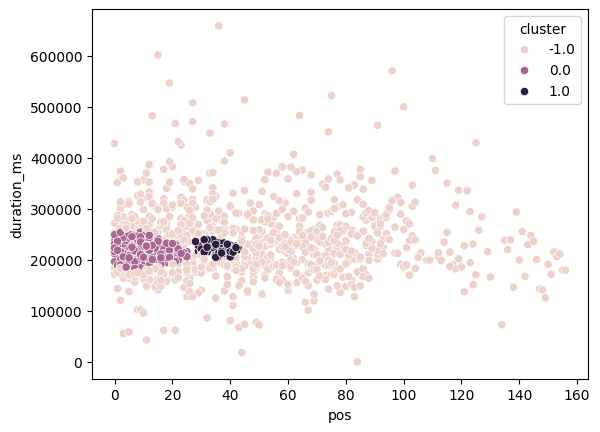

In [143]:
final_data_sample = final_data.loc[:1000, ['pos', 'duration_ms']]

fd_scaled = StandardScaler().fit_transform(final_data_sample)

dbscan = DBSCAN(eps=0.19712671753976277, min_samples=35)
final_data_sample['cluster'] = dbscan.fit_predict(fd_scaled)

sb.scatterplot(data=final_data, x='pos' , y=final_data_sample['duration_ms'], hue=final_data_sample['cluster'])
